In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import os

# os.environ["CUDA_VISIBLE_DEVICES"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
# how many samples per batch to load
batch_size = 32
# percentage of training set to use as validation
test_size = 0.3

transform = transforms.Compose([
    transforms.Resize(size=(32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [3]:
data = datasets.ImageFolder('face',transform=transform)


In [4]:

num_data = len(data)
indices_data = list(range(num_data))
np.random.shuffle(indices_data)
split_data = int(np.floor(test_size * num_data))
train_idexx, test_idexx = indices_data[split_data:], indices_data[:split_data]

train_sampler = SubsetRandomSampler(train_idexx)
test_sampler = SubsetRandomSampler(test_idexx)


In [5]:

train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,
    sampler  = train_sampler, num_workers=4)

test_loader  = torch.utils.data.DataLoader(data, batch_size=batch_size, 
    sampler  = test_sampler, num_workers=4)
classes = [0,1]

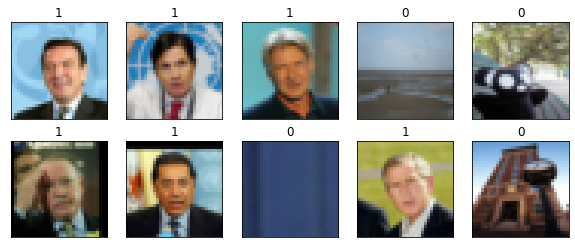

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(10, 4))
# display 20 images
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])
# images[31].shape

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import pdb

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer
        self.conv1 = nn.Conv2d(3, 6, 5)
        # max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=2)#nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv2_bn = nn.BatchNorm2d(16)
        self.conv2_2 = nn.Conv2d(6, 16, 5)
        self.conv2_2_bn = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 120, 5)
        self.conv3_bn = nn.BatchNorm2d(120)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc1_bn = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84)
        self.fc2_bn = nn.BatchNorm1d(84)
        self.fc3 = nn.Linear(84, 2)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
#         pdb.set_trace()
        x = self.pool(F.relu(self.conv1(x)))
#         pdb.set_trace()
        x1= self.pool(F.relu(self.conv2_2_bn(self.conv2_2(x))))
        x = self.pool(F.relu(self.conv2_bn(self.conv2(x))))
        
        x+=x1
#         pdb.set_trace()
        x = self.dropout(x)
#         pdb.set_trace()
        x = x.view(-1, 16 * 5 * 5)
#         pdb.set_trace()
        x = F.relu(self.fc1_bn(self.fc1(x)))
#         x = F.relu(self.fc2(x))
        x = self.dropout(F.relu(self.fc2_bn(self.fc2(x))))
#         pdb.set_trace()
        x = self.softmax(self.fc3(x))
        return x

model = Net()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)



Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2_2_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (conv3_bn): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc1_bn): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc2_bn): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_feature

In [8]:
import torch.optim as optim

# specify loss function
criterion = torch.nn.CrossEntropyLoss()
learning_rate1=2e-3
# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr =learning_rate1, momentum= 0.95,weight_decay=0.0)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,weight_decay=0)

In [9]:
# number of epochs to train the model
import pdb
n_epochs = 50 # you may increase this number to train a final model
import pdb
test_loss_s = np.Inf # track change in validation loss
# total_btach=len(final_train_data)//batch_size
tr_loss_hist=[]
test_loss_hist=[]
correct = 0
total = 0
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    test_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:

        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        
 ############# TESTING ##############
    model.eval()
    with torch.no_grad():
         for data, target in test_loader:
             data, target = data.to(device), target.to(device)
             output = model(data)
             loss = criterion(output, target)
             test_loss += loss.item()*data.size(0)
             _, pred = torch.max(output, 1)    
             total += target.size(0)
             correct += (pred == target).sum().item()
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    test_loss = test_loss/len(test_loader.dataset)
    tr_loss_hist.append(train_loss)
    test_loss_hist.append(test_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tTesting Accuracy: {:.6f}'.format(
        epoch, train_loss, np.sum(correct)/np.sum(total)))
    
    # save model if validation loss has dropped
    if test_loss <= test_loss_s:
        print('Test loss dropped ({:.6f} --> {:.6f}).  Saving model ...'.format(
        test_loss_s,
        test_loss))
        torch.save(model.state_dict(), 'model_face_1e_3.pt')
        test_loss_s = test_loss

Epoch: 1 	Training Loss: 0.188791 	Testing Accuracy: 0.958090
Test loss dropped (inf --> 0.034479).  Saving model ...
Epoch: 2 	Training Loss: 0.089137 	Testing Accuracy: 0.963010
Test loss dropped (0.034479 --> 0.027734).  Saving model ...
Epoch: 3 	Training Loss: 0.084840 	Testing Accuracy: 0.964650
Test loss dropped (0.027734 --> 0.025517).  Saving model ...
Epoch: 4 	Training Loss: 0.062320 	Testing Accuracy: 0.966837
Test loss dropped (0.025517 --> 0.021836).  Saving model ...
Epoch: 5 	Training Loss: 0.052841 	Testing Accuracy: 0.970262
Test loss dropped (0.021836 --> 0.015707).  Saving model ...
Epoch: 6 	Training Loss: 0.056761 	Testing Accuracy: 0.971331
Epoch: 7 	Training Loss: 0.045140 	Testing Accuracy: 0.972980
Epoch: 8 	Training Loss: 0.039147 	Testing Accuracy: 0.974262
Test loss dropped (0.015707 --> 0.015559).  Saving model ...
Epoch: 9 	Training Loss: 0.046902 	Testing Accuracy: 0.975583
Test loss dropped (0.015559 --> 0.014954).  Saving model ...
Epoch: 10 	Training 

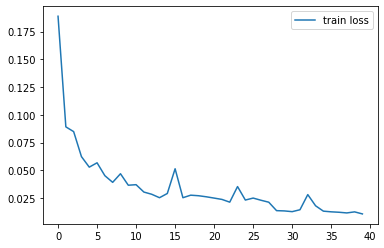

In [10]:
import matplotlib.pyplot as plt
plt.plot(tr_loss_hist,label='train loss')
# plt.plot(val_loss_hist,label='validation loss')
plt.savefig('lr_3.png',dip=200)
plt.legend()

In [11]:


train_loss = 0.0

correct = 0
total = 0
train_on_gpu=True
model.eval()
i=1
# iterate over test data
len(test_loader)
with torch.no_grad():
    for data, target in train_loader:
        data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()*data.size(0)
        _, pred = torch.max(output, 1)    
        total += target.size(0)
        correct += (pred == target).sum().item()

        
# average test loss
train_loss = train_loss/len(train_loader.dataset)
print('Train Loss: {:.6f}\n'.format(train_loss))

print('\nTrain Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(correct) / np.sum(total),
    np.sum(correct), np.sum(total)))

Train Loss: 0.002099


Train Accuracy (Overall): 99% (6402/6404)


In [12]:


test_loss = 0.0

correct = 0
total = 0
train_on_gpu=True
model.eval()
i=1
# iterate over test data
len(test_loader)
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        test_loss += loss.item()*data.size(0)
        _, pred = torch.max(output, 1)    
        total += target.size(0)
        correct += (pred == target).sum().item()

        
# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))


print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(correct) / np.sum(total),
    np.sum(correct), np.sum(total)))

Test Loss: 0.009420


Test Accuracy (Overall): 99% (2720/2744)
